# 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
import os
import warnings
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 훈련 데이터와 시험 데이터의 개수 파악

In [3]:
print('훈련용 데이터: {}개 , 시험 데이터: {}개'.format(len(train_data),len(test_data)))

훈련용 데이터: 150000개 , 시험 데이터: 50000개


# 2. 데이터 전처리

### 데이터 개수 확인 + 결측치 확인 + 제거

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
print('훈련데이터: {},   시험데이터: {}'.format(len(X_train), len(X_test)))

훈련데이터: 146182,   시험데이터: 49157


### 토큰화된 데이터 확인

In [9]:
print(X_train[0])
print('라벨: ', y_train[0]) 

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0


In [10]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### train 데이터의 길이랑 test 데이터의 길이를 맞춰야 된다.

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


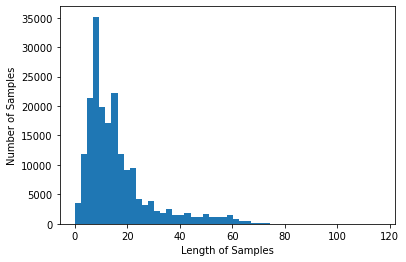

In [12]:
plt.hist(num_tokens, bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

['post' 말고 'pre' 사용하는 이유](https://blog.naver.com/qbxlvnf11/221945962124)

In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [14]:
print(X_train[-1])
print(X_test[-1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  181    5 1945   29    2    8   88 2740    5]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1009  179   63 1058]


In [15]:
print(get_decoded_sentence(X_train[-1], index_to_word))
print('라벨: ', y_train[-1])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 한국 영화 최초 로 <UNK> 하 내용 담긴 영화
라벨:  0


In [16]:
print(get_decoded_sentence(X_test[-1], index_to_word))
print('라벨: ', y_test[-1])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 마무리 또 왜 이래
라벨:  0


# 3. 여러가지 모델 사용해보기

In [17]:
vocab_size = 10000
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

### 검증 데이터 나누기

In [18]:
# validation set X_train set의 20% 분리
x_val = X_train[:29200]   
y_val = y_train[:29200]

# validation set을 제외한 나머지
partial_x_train = X_train[29200:]  
partial_y_train = y_train[29200:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116982, 41)
(116982,)


## 1) RNN

In [19]:
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


In [20]:
RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = RNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3656/3656 [==============================] - 22s 5ms/step - loss: 0.3786 - accuracy: 0.8289 - val_loss: 0.3336 - val_accuracy: 0.8538
Epoch 2/5
3656/3656 [==============================] - 18s 5ms/step - loss: 0.2991 - accuracy: 0.8706 - val_loss: 0.3203 - val_accuracy: 0.8617
Epoch 3/5
3656/3656 [==============================] - 18s 5ms/step - loss: 0.2608 - accuracy: 0.8892 - val_loss: 0.3316 - val_accuracy: 0.8616
Epoch 4/5
3656/3656 [==============================] - 18s 5ms/step - loss: 0.2307 - accuracy: 0.9048 - val_loss: 0.3506 - val_accuracy: 0.8581
Epoch 5/5
3656/3656 [==============================] - 18s 5ms/step - loss: 0.2051 - accuracy: 0.9160 - val_loss: 0.3767 - val_accuracy: 0.8574


### 그래프 분석 RNN

In [21]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


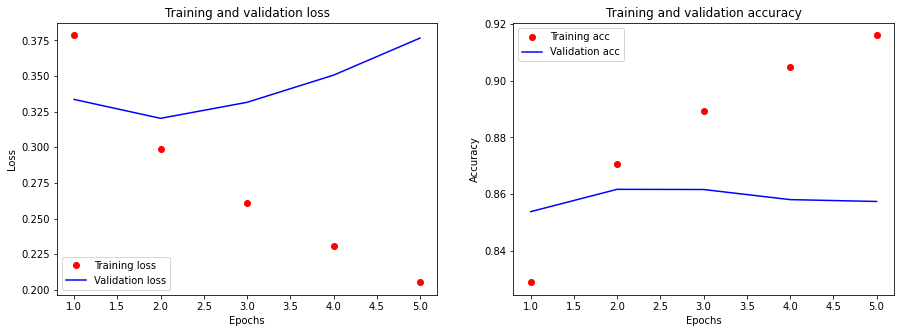

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
results = RNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3804 - accuracy: 0.8527
[0.38036343455314636, 0.8526760935783386]


### embedding layer (RNN)

In [24]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/RNNword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = RNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.14407139,  0.08724835,  0.01504255,  0.02275497, -0.05565699,
        0.06801142, -0.04052428,  0.1451029 , -0.04252971,  0.05362587,
       -0.12379825,  0.05535479,  0.04421499, -0.09873541, -0.12774138,
       -0.00964929, -0.07932693, -0.2091995 , -0.01721791,  0.04997775,
        0.03381173, -0.01983873,  0.09888999,  0.08759838, -0.04847975,
        0.08020575,  0.11280472,  0.09640181,  0.04797148,  0.04294715,
       -0.07912029, -0.07685395], dtype=float32)

In [27]:
word_vectors.similar_by_word("실망")

[('재미없', 0.9785269498825073),
 ('가관', 0.9690766334533691),
 ('실패작', 0.9678778052330017),
 ('어색', 0.9674192070960999),
 ('잤', 0.9656728506088257),
 ('문란', 0.957480788230896),
 ('비추', 0.9571312665939331),
 ('후지', 0.9557182788848877),
 ('버린다', 0.9549447298049927),
 ('자니', 0.9534690380096436)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선 (RNN)

In [28]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin.gz'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [29]:
word2vec.similar_by_word("실망")

[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

In [30]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [31]:
# 모델 구성
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
RNN_model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [32]:
RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = RNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3656/3656 [==============================] - 21s 5ms/step - loss: 0.4106 - accuracy: 0.8100 - val_loss: 0.3412 - val_accuracy: 0.8510
Epoch 2/5
3656/3656 [==============================] - 20s 6ms/step - loss: 0.3102 - accuracy: 0.8686 - val_loss: 0.3291 - val_accuracy: 0.8564
Epoch 3/5
3656/3656 [==============================] - 20s 5ms/step - loss: 0.2747 - accuracy: 0.8848 - val_loss: 0.3260 - val_accuracy: 0.8599
Epoch 4/5
3656/3656 [==============================] - 20s 5ms/step - loss: 0.2447 - accuracy: 0.8996 - val_loss: 0.3354 - val_accuracy: 0.8592
Epoch 5/5
3656/3656 [==============================] - 20s 5ms/step - loss: 0.2176 - accuracy: 0.9117 - val_loss: 0.3492 - val_accuracy: 0.8584


In [34]:
results = RNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3588 - accuracy: 0.8544
[0.3587951958179474, 0.8544052839279175]


## 2) 1-D Convolution Neural Network(1-D CNN)

In [35]:
CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [36]:
CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = CNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3656/3656 [==============================] - 19s 5ms/step - loss: 0.3753 - accuracy: 0.8265 - val_loss: 0.3202 - val_accuracy: 0.8617
Epoch 2/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.2620 - accuracy: 0.8920 - val_loss: 0.3248 - val_accuracy: 0.8609
Epoch 3/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.1782 - accuracy: 0.9310 - val_loss: 0.3734 - val_accuracy: 0.8527
Epoch 4/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.1132 - accuracy: 0.9587 - val_loss: 0.4954 - val_accuracy: 0.8442
Epoch 5/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.0812 - accuracy: 0.9702 - val_loss: 0.5631 - val_accuracy: 0.8421


### 그래프 분석 1-D Convolution Neural Network(1-D CNN)

In [37]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


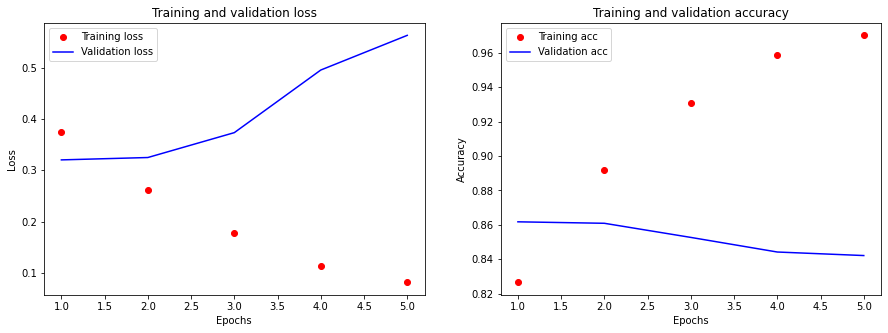

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.5745 - accuracy: 0.8387
[0.5744879841804504, 0.8387208580970764]


### embedding layer (1-D Convolution Neural Network(1-D CNN)

In [40]:
embedding_layer = CNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [41]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/CNNword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-9.41210315e-02,  9.54017416e-02,  7.69393053e-03, -1.18003665e-02,
        1.16658293e-01,  6.76655993e-02, -5.32102399e-02, -1.37610301e-01,
        2.29320526e-02,  9.89811867e-02,  3.29777598e-02, -7.88691416e-02,
       -1.75196566e-02, -1.90004129e-02,  1.62760168e-01,  1.35699943e-01,
       -7.82043114e-02,  5.31749055e-02,  4.81083654e-02, -3.58590744e-02,
        9.02787298e-02, -9.08359215e-02,  1.58882439e-02,  6.70951158e-02,
        4.24925387e-02, -2.47382210e-04, -7.32346997e-02,  7.79194534e-02,
        1.33616462e-01,  1.68653987e-02,  4.95464951e-02,  3.13038528e-02,
        7.56136701e-02,  5.99132963e-02,  6.71788454e-02, -2.63488553e-02,
       -7.08514601e-02, -1.13793723e-02,  5.90698086e-02, -1.67728290e-02,
       -1.26168773e-01,  6.33578226e-02, -5.70801608e-02,  6.55129505e-03,
        2.26852410e-02, -8.34240019e-02,  1.19939789e-01,  1.01862438e-01,
        4.61558951e-03, -2.16931961e-02,  8.22593421e-02, -1.26768462e-02,
        3.33022401e-02,  

In [43]:
word_vectors.similar_by_word("실망")

[('떨어집니다', 0.8158352375030518),
 ('가관', 0.8035213351249695),
 ('불친절', 0.8001257181167603),
 ('문란', 0.7880607843399048),
 ('해놨', 0.7849583625793457),
 ('흑역사', 0.7825869917869568),
 ('.-', 0.774508535861969),
 ('에휴', 0.7735586166381836),
 ('부실', 0.7725807428359985),
 ('잘못', 0.7695517539978027)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선 (CNN)

In [44]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin.gz'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [45]:
word2vec.similar_by_word("실망")

[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

In [46]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [47]:
# 모델 구성
CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [48]:
CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
history = CNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3656/3656 [==============================] - 18s 5ms/step - loss: 0.4355 - accuracy: 0.7925 - val_loss: 0.3504 - val_accuracy: 0.8449
Epoch 2/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.3240 - accuracy: 0.8609 - val_loss: 0.3340 - val_accuracy: 0.8550
Epoch 3/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.2842 - accuracy: 0.8813 - val_loss: 0.3305 - val_accuracy: 0.8570
Epoch 4/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.2495 - accuracy: 0.8976 - val_loss: 0.3519 - val_accuracy: 0.8561
Epoch 5/5
3656/3656 [==============================] - 17s 5ms/step - loss: 0.2160 - accuracy: 0.9132 - val_loss: 0.3650 - val_accuracy: 0.8529


In [50]:
results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3761 - accuracy: 0.8503
[0.3761356770992279, 0.8502553105354309]


## 3) GlobalMaxPooling1D()

In [51]:
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [52]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
3656/3656 [==============================] - 14s 4ms/step - loss: 0.3826 - accuracy: 0.8302 - val_loss: 0.3378 - val_accuracy: 0.8526
Epoch 2/5
3656/3656 [==============================] - 13s 4ms/step - loss: 0.2956 - accuracy: 0.8762 - val_loss: 0.3364 - val_accuracy: 0.8575
Epoch 3/5
3656/3656 [==============================] - 13s 4ms/step - loss: 0.2426 - accuracy: 0.9019 - val_loss: 0.3492 - val_accuracy: 0.8564
Epoch 4/5
3656/3656 [==============================] - 13s 4ms/step - loss: 0.1908 - accuracy: 0.9262 - val_loss: 0.3851 - val_accuracy: 0.8516
Epoch 5/5
3656/3656 [==============================] - 13s 3ms/step - loss: 0.1412 - accuracy: 0.9476 - val_loss: 0.4641 - val_accuracy: 0.8474


### 그래프 분석 GlobalMaxPooling1D()

In [53]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


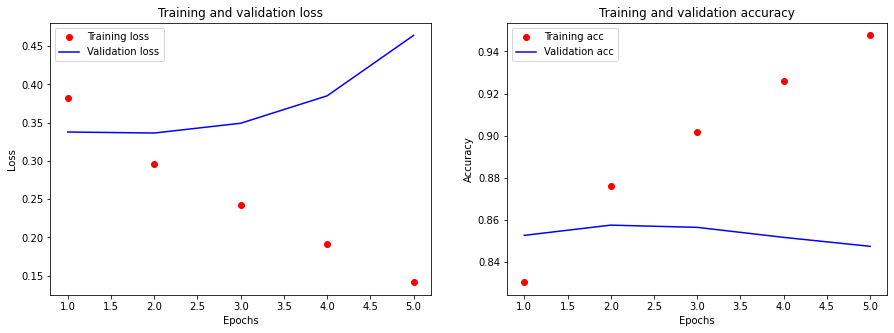

In [54]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [55]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4651 - accuracy: 0.8435
[0.46505850553512573, 0.8435014486312866]


### embedding layer (GlobalMaxPooling1D)

In [56]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [57]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GMPword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [58]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.1256925 , -0.19091079, -0.11137646, -0.13867183,  0.04315162,
       -0.08418351, -0.15381636, -0.24816352, -0.12120295, -0.19711234,
       -0.11917408, -0.23065074, -0.04279614, -0.05806922, -0.14056818,
       -0.16186434, -0.22422054, -0.11388251, -0.13019413, -0.28739792,
        0.01979981, -0.14719585,  0.01939621,  0.25167447, -0.08313365,
       -0.10854414, -0.05925051, -0.20406431, -0.09144842, -0.09776396,
        0.20334628, -0.198129  , -0.05672632, -0.17734568, -0.15402938,
       -0.06423121, -0.08377635,  0.09160884, -0.12805244, -0.08176218,
       -0.13317674, -0.23783594, -0.11256407, -0.20388387, -0.2343159 ,
       -0.06588906,  0.08883683, -0.19089659, -0.1238077 , -0.06926543,
       -0.08131389,  0.17791207, -0.1289887 , -0.10792688, -0.20816551,
       -0.29139346, -0.29262716, -0.18842295, -0.13595897, -0.24439204,
       -0.26300102, -0.25587383, -0.1170483 , -0.16995458,  0.38983148,
       -0.1368109 , -0.17458129,  0.01495867, -0.10778385,  0.17

In [59]:
word_vectors.similar_by_word("실망")

[('애매', 0.6789845824241638),
 ('구려', 0.6283780336380005),
 ('난장판', 0.6094778180122375),
 ('그만', 0.605902373790741),
 ('한심', 0.6030822992324829),
 ('오버', 0.5982528924942017),
 ('망치', 0.5982508659362793),
 ('때려', 0.5979940891265869),
 ('별루', 0.5921976566314697),
 ('잔', 0.5901636481285095)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선 (GlobalMaxPooling1D)

In [60]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin.gz'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [61]:
word2vec.similar_by_word("실망")

[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

In [62]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [63]:
# 모델 구성
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [64]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=7,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.5405 - accuracy: 0.7207 - val_loss: 0.4443 - val_accuracy: 0.7922
Epoch 2/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.4138 - accuracy: 0.8106 - val_loss: 0.4028 - val_accuracy: 0.8166
Epoch 3/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.3654 - accuracy: 0.8382 - val_loss: 0.3843 - val_accuracy: 0.8272
Epoch 4/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.3300 - accuracy: 0.8570 - val_loss: 0.4081 - val_accuracy: 0.8182
Epoch 5/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.3020 - accuracy: 0.8724 - val_loss: 0.3778 - val_accuracy: 0.8362
Epoch 6/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.2767 - accuracy: 0.8854 - val_loss: 0.3790 - val_accuracy: 0.8381
Epoch 7/7
3656/3656 [==============================] - 13s 3ms/step - loss: 0.2538 - accuracy: 0.8964 - val_loss: 0.3894 - val_accuracy:

In [66]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4020 - accuracy: 0.8307
[0.40197697281837463, 0.8306853771209717]


# 회고

[batch size setting](https://blog.naver.com/qbxlvnf11/221449595336)

기존 노드에서 진행했던 배치 사이즈(512)가 문제가 있다고 판단해서 구글링을 통해서 알아낸 미니 배치 사이즈 방법으로 세팅한 후, 손실함수 그래프를 보고 epochs를 줄여서 좋은 결과를 얻을 수 있었다. 한국어 임베딩을 진행하면서 gensim 버전이 4.0.0 보다 높아서 Vocab이 포함되어 있지않다는 오류가 발생했다. 버전을 3.8.3으로 업데이트하는 것으로 문제를 해결했다. 한국어 임베딩 시 기존에 구했던 값보다 낮게 나오는 경우가 있었는데 내 생각에는 데이터 양이 많아서 과적합이 일어나는 것이라고 판단되었다. 그래서 epochs의 값을 반으로 줄여서 측정한 결과 85%가 넘는 결과를 얻을 수 있었다. GlobalMaxPooling1D 같은 경우 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환하기 때문에 단어장을 10000개만 구성 했기때문에 결과값이 부족하게 나왔던 것 같다.